# Set up

In [1]:
from dask.distributed import Client, LocalCluster
import dask

# Create a local cluster with dashboard
cluster = LocalCluster()

# Connect client to the cluster
client = Client(cluster)

In [2]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/dhruvbalwada/server2/proxy/8787/status,
Dashboard: /user/dhruvbalwada/server2/proxy/8787/status,Workers: 4
Total threads: 16,Total memory: 125.80 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:43229,Workers: 0
Dashboard: /user/dhruvbalwada/server2/proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:39427,Total threads: 4
Dashboard: /user/dhruvbalwada/server2/proxy/38131/status,Memory: 31.45 GiB
Nanny: tcp://127.0.0.1:38093,


In [3]:
import torch
import torch.nn as nn
import numpy as np
import xarray as xr
from torch.utils.data import TensorDataset, DataLoader
from train import apply_inverse_zca_whitening_4d_torch
from unet import UNet  
from utils import *
from tqdm import tqdm


setup_random_seeds(42)
device = get_device()

base_path = "gs://leap-persistent/YueWang/SSH/data"
storage_opts = {"token": "cloud", "asynchronous": False}

train = open_zarr(f"{base_path}/train_80_sst.zarr", storage_opts)
test = open_zarr(f"{base_path}/test_80_sst.zarr", storage_opts)
zca = open_zarr(f"{base_path}/zca_80.zarr", storage_opts)

Vt = torch.from_numpy(zca.ubm_Vt.values).float().to(device)
scale = torch.from_numpy(zca.ubm_scale.values).float().to(device)
mean = torch.from_numpy(zca.ubm_mean.values).float().to(device)

Using device: cpu


/srv/conda/envs/notebook/lib/python3.12/site-packages/zarr/storage/_fsspec.py:256: UserWarning: fs (<gcsfs.core.GCSFileSystem object at 0x79509325bc50>) was not created with `asynchronous=True`, this may lead to surprising behavior
  return cls(fs=fs, path=path, read_only=read_only, allowed_exceptions=allowed_exceptions)
/srv/conda/envs/notebook/lib/python3.12/site-packages/zarr/storage/_fsspec.py:256: UserWarning: fs (<gcsfs.core.GCSFileSystem object at 0x79509325bc50>) was not created with `asynchronous=True`, this may lead to surprising behavior
  return cls(fs=fs, path=path, read_only=read_only, allowed_exceptions=allowed_exceptions)
/srv/conda/envs/notebook/lib/python3.12/site-packages/zarr/storage/_fsspec.py:256: UserWarning: fs (<gcsfs.core.GCSFileSystem object at 0x79509325bc50>) was not created with `asynchronous=True`, this may lead to surprising behavior
  return cls(fs=fs, path=path, read_only=read_only, allowed_exceptions=allowed_exceptions)


In [4]:
%%time
# Model 1: ZCA NLL Loss with SSH+SST input

# Prepare training data for normalization statistics (SSH+SST)
x_train_ssh = torch.from_numpy(train.ssh.values).float().unsqueeze(1).to(device)
x_train_sst = torch.from_numpy(train.sst.values).float().unsqueeze(1).to(device)
x_train = torch.cat([x_train_ssh, x_train_sst], dim=1)
x_train_normalized, min_vals_sst, max_vals_sst = min_max_normalize(x_train)

# Prepare test data (SSH+SST) 
x_test_ssh_original = torch.from_numpy(test.ssh.values).float().unsqueeze(1).to(device)
x_test_sst_original = torch.from_numpy(test.sst.values).float().unsqueeze(1).to(device)
x_test_original = torch.cat([x_test_ssh_original, x_test_sst_original], dim=1)

# Normalize test data for model input
x_test_normalized, _, _ = min_max_normalize(x_test_original, min_vals_sst, max_vals_sst)

# Prepare test targets
y_test_physical = torch.from_numpy(test.ubm.values).float().unsqueeze(1).to(device)
y_test_zca = torch.from_numpy(test.zca_ubm.values).float().unsqueeze(1).to(device)
y_test = torch.cat([y_test_physical, y_test_zca], dim=1)

# Create test dataset and loader
test_dataset_sst = TensorDataset(x_test_normalized, y_test)
test_loader_sst = DataLoader(test_dataset_sst, batch_size=32*4, shuffle=False)

# Load model
model_sst_ssh = UNet(in_channels=2, out_channels=2, initial_features=32, depth=4)
model_sst_ssh.to(device)

checkpoint = torch.load('/home/jovyan/GRL_ssh/checkpoints/sst_ssh.pth', map_location=device)
model_sst_ssh.load_state_dict(checkpoint['model_state_dict'])

# Evaluate model
model_sst_ssh.eval()
results_sst_ssh = {
    'ssh': [], 'sst': [], 'ubm_true': [], 'bm_true': [],
    'ubm_pred_mu': [], 'bm_pred_mu': [],
    'ubm_pred_ensembles': [], 'bm_pred_ensembles': []
}

sample_indices = []

with torch.no_grad():
    for i, (batch_x, batch_y) in enumerate(tqdm(test_loader_sst)):
        
        batch_start = i * test_loader_sst.batch_size
        batch_end = min(batch_start + test_loader_sst.batch_size, len(test_dataset_sst))
        current_batch_indices = list(range(batch_start, batch_end))
        sample_indices.extend(current_batch_indices)
        
        batch_x = batch_x.to(device)
        batch_y_physical = batch_y[:, 0:1, ...].to(device)

        outputs = model_sst_ssh(batch_x)
        
        ssh_batch_original = x_test_ssh_original[current_batch_indices]
        sst_batch_original = x_test_sst_original[current_batch_indices]
        
        ubm_true = batch_y_physical
        bm_true = ssh_batch_original - ubm_true
        
        # Predicted mean in physical space
        mu_zca = outputs[:, 0, ...]
        log_sigma_zca = outputs[:, 1, ...]
        mu_zca_expanded = mu_zca.unsqueeze(1)
        ubm_pred_mu = apply_inverse_zca_whitening_4d_torch(mu_zca_expanded, Vt, scale, mean)
        
        bm_pred_mu = ssh_batch_original - ubm_pred_mu
        
        # Generate ensemble samples
        zca_samples = generate_gaussian_samples(mu_zca, log_sigma_zca, n_samples=100)
        B, n_samples, H, W = zca_samples.shape
        zca_samples_flat = zca_samples.reshape(B * n_samples, 1, H, W)
        ubm_samples_flat = apply_inverse_zca_whitening_4d_torch(zca_samples_flat, Vt, scale, mean)
        ubm_samples = ubm_samples_flat.reshape(B, n_samples, 1, H, W)
        
        # Use original SSH for ensemble BM calculation
        ssh_expanded = ssh_batch_original.unsqueeze(1).expand(-1, n_samples, -1, -1, -1)
        bm_samples = ssh_expanded - ubm_samples
        
        # Store results 
        results_sst_ssh['ssh'].append(ssh_batch_original.cpu().numpy())
        results_sst_ssh['sst'].append(sst_batch_original.cpu().numpy())
        results_sst_ssh['ubm_true'].append(ubm_true.cpu().numpy())
        results_sst_ssh['bm_true'].append(bm_true.cpu().numpy())
        results_sst_ssh['ubm_pred_mu'].append(ubm_pred_mu.cpu().numpy())
        results_sst_ssh['bm_pred_mu'].append(bm_pred_mu.cpu().numpy())
        results_sst_ssh['ubm_pred_ensembles'].append(ubm_samples.cpu().numpy())
        results_sst_ssh['bm_pred_ensembles'].append(bm_samples.cpu().numpy())

for key in results_sst_ssh:
    results_sst_ssh[key] = np.concatenate(results_sst_ssh[key], axis=0)

print("Model 1 evaluation complete!")

<timed exec>:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
100%|██████████| 29/29 [09:45<00:00, 20.18s/it]


Model 1 evaluation complete!
CPU times: user 9min 23s, sys: 1min, total: 10min 24s
Wall time: 10min 1s


In [5]:
# Create xarray datasets and save results
models_results = [
    ('sst_ssh', results_sst_ssh, True, True),
    #('ssh_only', results_ssh_only, True, False), 
    #('mse_only', results_mse_only, False, True)
]

# Store all datasets
eval_datasets = {}

for model_name, results, has_ensembles, has_sst in models_results:
    print(f"Creating dataset for {model_name}...")
    
    eval_dataset = create_evaluation_dataset(results, model_name, has_ensembles, has_sst, stochastic_samples=100)
    
    # Store the dataset
    eval_datasets[model_name] = eval_dataset

Creating dataset for sst_ssh...
Adding ensemble data with shape: (3645, 100, 1, 80, 80)


In [6]:
# Chunk for some parallelization (not needed, but makes things potentially faster)
# Add km coordinates

#for k in eval_datasets.keys(): 
    #eval_datasets[k] = eval_datasets[k].chunk(chunks={'sample' : 100, 'stochastic_sample':100}) 
#    eval_datasets[k] = eval_datasets[k].assign_coords(i = eval_datasets[k].i *1.5, j = eval_datasets[k].j *1.5)

In [7]:
clean_mask = ~test.ubm.isnull().any(dim=("i", "j")).values
clean_idx  = np.where(clean_mask)[0]

In [8]:
clean_idx

array([  28,   29,   30, ..., 3609, 3610, 3611], shape=(2907,))

# Some plots to understand the data

In [10]:
import matplotlib.pyplot as plt

/srv/conda/envs/notebook/lib/python3.12/site-packages/distributed/client.py:3363: UserWarning: Sending large graph of size 88.99 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


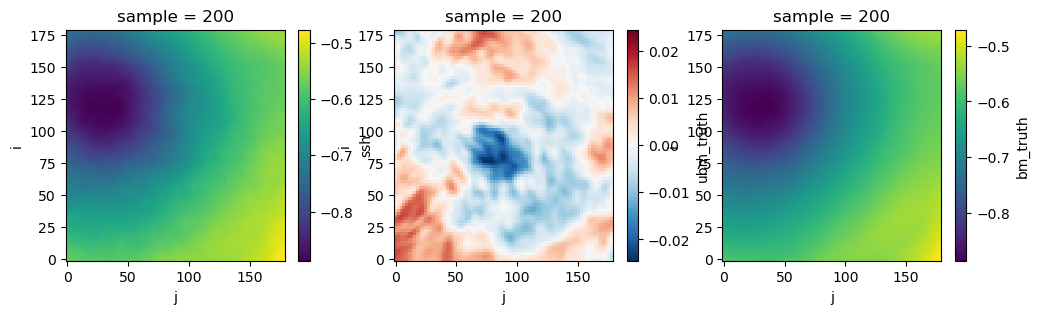

In [11]:
nsamp=200

plt.figure(figsize = (12, 3))

plt.subplot(131)
eval_datasets['sst_ssh'].ssh.isel(sample=nsamp).plot()

plt.subplot(132)
eval_datasets['sst_ssh'].ubm_truth.isel(sample=nsamp).plot()

plt.subplot(133)
eval_datasets['sst_ssh'].bm_truth.isel(sample=nsamp).plot()


/srv/conda/envs/notebook/lib/python3.12/site-packages/distributed/client.py:3363: UserWarning: Sending large graph of size 8.69 GiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


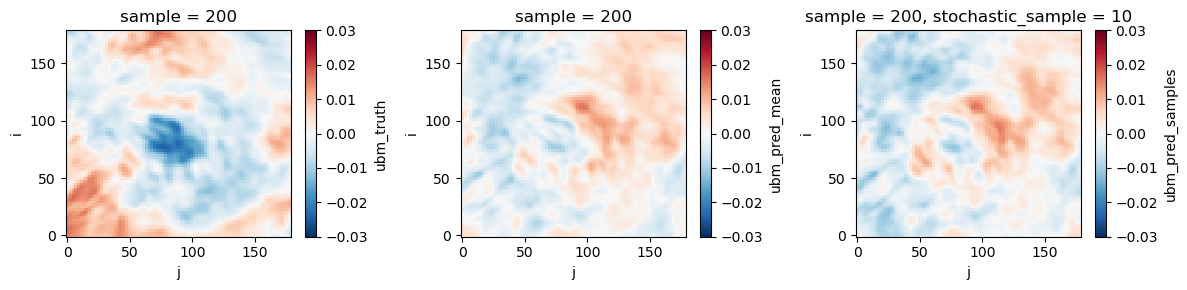

In [12]:
#nsamp=100

plt.figure(figsize = (12, 3))

plt.subplot(131)
eval_datasets['sst_ssh'].ubm_truth.isel(sample=nsamp).plot(vmin = -0.03)

plt.subplot(132)
eval_datasets['sst_ssh'].ubm_pred_mean.isel(sample=nsamp).plot(vmin = -0.03)

plt.subplot(133)
eval_datasets['sst_ssh'].ubm_pred_samples.isel(stochastic_sample = 10, sample=nsamp).plot(vmin = -0.03)

plt.tight_layout()

/srv/conda/envs/notebook/lib/python3.12/site-packages/distributed/client.py:3363: UserWarning: Sending large graph of size 2.69 GiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.12/site-packages/distributed/client.py:3363: UserWarning: Sending large graph of size 2.69 GiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


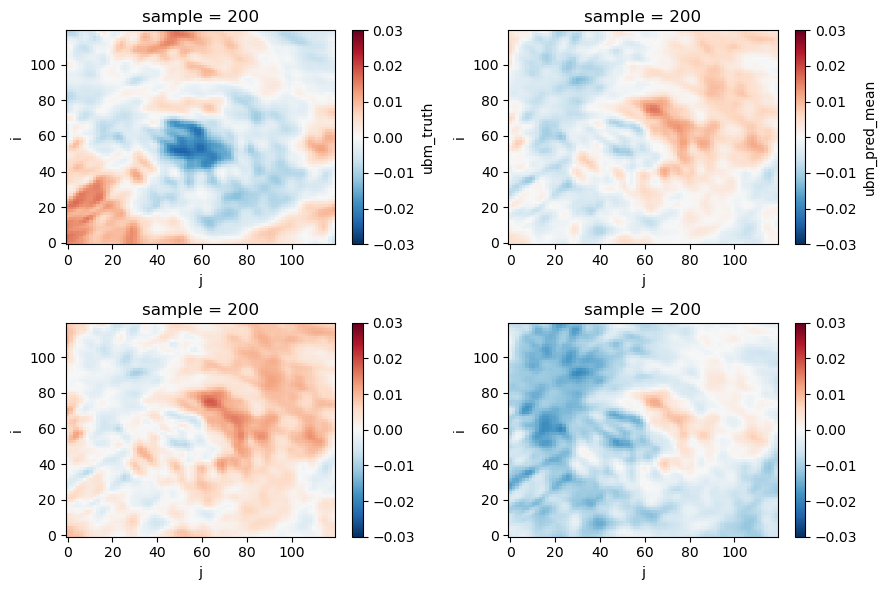

In [12]:
#nsamp=100

plt.figure(figsize = (9, 6))

plt.subplot(221)
eval_datasets['sst_ssh'].ubm_truth.isel(sample=nsamp).plot(vmin = -0.03)

plt.subplot(222)
eval_datasets['sst_ssh'].ubm_pred_mean.isel(sample=nsamp).plot(vmin = -0.03)

plt.subplot(223)
(eval_datasets['sst_ssh'].ubm_pred_mean.isel(sample=nsamp) + 
 eval_datasets['sst_ssh'].ubm_pred_samples.isel(sample=nsamp).std('stochastic_sample')).plot(vmin=-0.03)

plt.subplot(224)
(eval_datasets['sst_ssh'].ubm_pred_mean.isel(sample=nsamp) - 
 2*eval_datasets['sst_ssh'].ubm_pred_samples.isel(sample=nsamp).std('stochastic_sample')).plot(vmin=-0.03)


plt.tight_layout()

/srv/conda/envs/notebook/lib/python3.12/site-packages/distributed/client.py:3363: UserWarning: Sending large graph of size 88.99 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.12/site-packages/distributed/client.py:3363: UserWarning: Sending large graph of size 2.61 GiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.12/site-packages/distributed/client.py:3363: UserWarning: Sending large graph of size 2.61 GiB.
This may cause some slowdown.


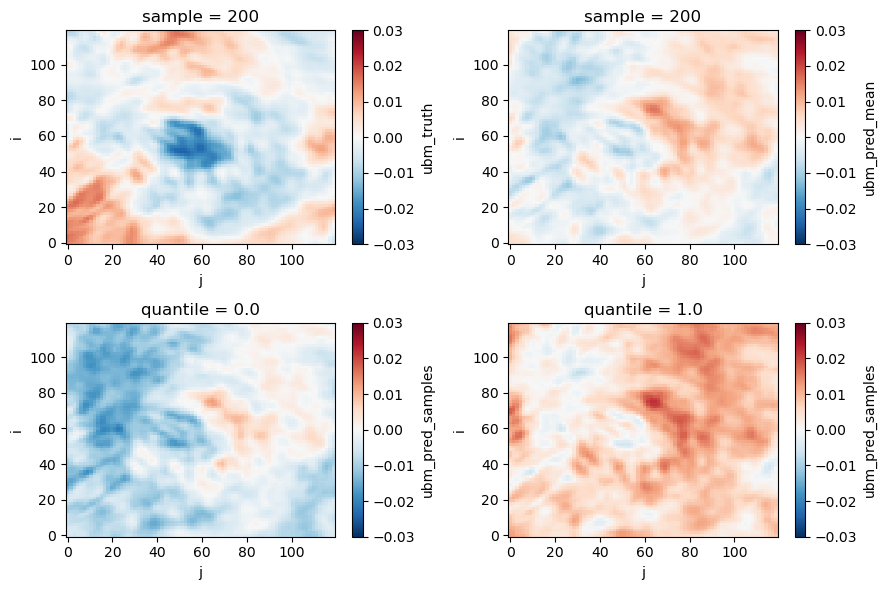

In [13]:
#nsamp=200

plt.figure(figsize = (9, 6))

plt.subplot(221)
eval_datasets['sst_ssh'].ubm_truth.isel(sample=nsamp).plot(vmin = -0.03)

plt.subplot(222)
eval_datasets['sst_ssh'].ubm_pred_mean.isel(sample=nsamp).plot(vmin = -0.03)

plt.subplot(223)
(eval_datasets['sst_ssh'].ubm_pred_samples.isel(sample=nsamp).quantile(0, 'stochastic_sample')).plot(vmin=-0.03)

plt.subplot(224)
(eval_datasets['sst_ssh'].ubm_pred_samples.isel(sample=nsamp).quantile(1, 'stochastic_sample')).plot(vmin=-0.03)


plt.tight_layout()

/srv/conda/envs/notebook/lib/python3.12/site-packages/distributed/client.py:3363: UserWarning: Sending large graph of size 88.99 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.12/site-packages/distributed/client.py:3363: UserWarning: Sending large graph of size 2.61 GiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.12/site-packages/distributed/client.py:3363: UserWarning: Sending large graph of size 2.61 GiB.
This may cause some slowdown.


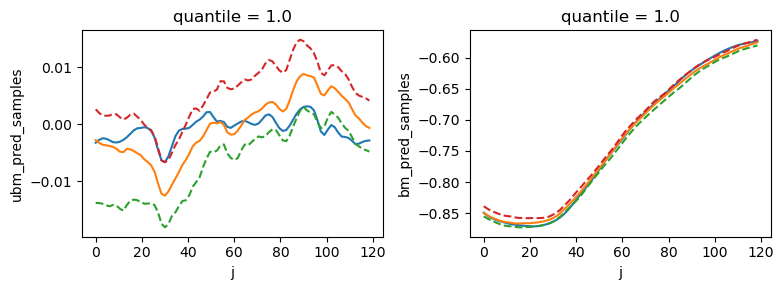

In [14]:
nsamp=200
ipt = 60

plt.figure(figsize=(8,3))

plt.subplot(121) 
eval_datasets['sst_ssh'].ubm_truth.isel(sample=nsamp, i=ipt).plot()
eval_datasets['sst_ssh'].ubm_pred_mean.isel(sample=nsamp, i=ipt).plot()
(eval_datasets['sst_ssh'].ubm_pred_samples.isel(sample=nsamp,i=ipt).quantile(0, 'stochastic_sample')).plot(linestyle='dashed')
(eval_datasets['sst_ssh'].ubm_pred_samples.isel(sample=nsamp,i=ipt).quantile(1, 'stochastic_sample')).plot(linestyle='dashed')


plt.subplot(122)
eval_datasets['sst_ssh'].bm_truth.isel(sample=nsamp, i=ipt).plot()
eval_datasets['sst_ssh'].bm_pred_mean.isel(sample=nsamp, i=ipt).plot()
(eval_datasets['sst_ssh'].bm_pred_samples.isel(sample=nsamp,i=ipt).quantile(0, 'stochastic_sample')).plot(linestyle='dashed')
(eval_datasets['sst_ssh'].bm_pred_samples.isel(sample=nsamp,i=ipt).quantile(1, 'stochastic_sample')).plot(linestyle='dashed')

plt.tight_layout()

# Bin by where 

In [9]:
# Analysis by PSD Intersection Bins (Log-spaced)
import warnings
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import xarray as xr
import xrft
from scipy.interpolate import interp1d
from tqdm import tqdm

# Suppress warnings
warnings.filterwarnings('ignore')

def isotropic_spectra(data):
    """Calculate the isotropic power spectrum of input data."""
    iso_psd = xrft.isotropic_power_spectrum(
        data, 
        dim=['i', 'j'], 
        detrend='constant', 
        window=True,
        nfactor=2
    )
    return iso_psd

def calculate_psd_km(field, dx=1.5):
    """Calculate PSD with spatial coordinates in km."""
    i_km = np.arange(field.shape[0]) * dx
    j_km = np.arange(field.shape[1]) * dx
    da = xr.DataArray(
        field,
        dims=['i', 'j'],
        coords={'i': i_km, 'j': j_km},
        name='field'
    )
    return isotropic_spectra(da)



def find_psd_intersection(bm_psd, ubm_psd, wavenumbers):
    """Find the first intersection point (smallest wavenumber) between BM and UBM PSDs"""
    try:
        # Find where UBM crosses above BM (or vice versa)
        diff = ubm_psd - bm_psd
        
        # Look for sign changes
        sign_changes = np.where(np.diff(np.sign(diff)))[0]
        
        if len(sign_changes) == 0:
            return None  # No intersection found
        
        # Return the wavenumber of the first intersection (smallest wavenumber)
        first_intersection_idx = sign_changes[0]
        
        # Linear interpolation to get more precise intersection point
        k1, k2 = wavenumbers[first_intersection_idx], wavenumbers[first_intersection_idx + 1]
        d1, d2 = diff[first_intersection_idx], diff[first_intersection_idx + 1]
        
        # Linear interpolation: find where diff crosses zero
        intersection_k = k1 - d1 * (k2 - k1) / (d2 - d1)
        
        return intersection_k
        
    except Exception as e:
        return None

def create_log_bins(k_min=1/120, k_max=1/2, n_bins=3):
    """Create equally spaced log bins across the wavenumber range"""
    log_min = np.log10(k_min)
    log_max = np.log10(k_max)
    
    # Create bin edges in log space
    log_edges = np.linspace(log_min, log_max, n_bins + 1)
    bin_edges = 10**log_edges
    
    return bin_edges

def bin_samples_by_intersection_logspace(eval_dataset, test_data, clean_idx_subset):
    """Bin samples based on BM-UBM PSD intersection wavenumbers using log-spaced bins"""
    
    # Create 4 equally spaced log bins
    bin_edges = create_log_bins()
    n_bins = len(bin_edges) - 1
    
    # Initialize bins
    bins = {f'bin_{i}': [] for i in range(n_bins)}
    no_intersection_samples = []
    intersection_wavenumbers = []

    print("Bin edges (spatial scale in km):")
    for i in range(n_bins):
        km_low = 1/bin_edges[i+1]  # Note: reversed order since 1/k
        km_high = 1/bin_edges[i]
        print(f"Bin {i+1}: [{km_low:.1f}, {km_high:.1f}) km")
    
    # print("Bin edges (wavenumber):")
    # for i in range(n_bins):
    #     print(f"Bin {i+1}: [{bin_edges[i]:.4f}, {bin_edges[i+1]:.4f})")
    
    for sample_idx in tqdm(clean_idx_subset): #!! these kind of for loops are very slow.
        try:
            # Get true BM and UBM for this sample
            bm_true = eval_dataset.bm_truth.isel(sample=sample_idx).values
            ubm_true = eval_dataset.ubm_truth.isel(sample=sample_idx).values
            
            # Skip samples with NaNs
            if np.any(np.isnan(bm_true)) or np.any(np.isnan(ubm_true)):
                continue
                
            # Calculate PSDs
            psd_bm = calculate_psd_km(bm_true)
            #psd_bm = isotropic_spectra(bm_true)
            psd_ubm = calculate_psd_km(ubm_true)
            #psd_ubm = isotropic_spectra(ubm_true)
            
            wavenumbers = psd_bm[list(psd_bm.coords.keys())[0]].values
            
            # Find intersection
            intersection_k = find_psd_intersection(psd_bm.values, psd_ubm.values, wavenumbers)
            
            # Bin the sample
            if intersection_k is None:
                no_intersection_samples.append(sample_idx)
            else:
                intersection_wavenumbers.append(intersection_k)
                
                # Find which bin this intersection falls into
                bin_idx = np.digitize(intersection_k, bin_edges) - 1
                
                # Make sure it's within valid range
                if 0 <= bin_idx < n_bins:
                    bins[f'bin_{bin_idx}'].append(sample_idx)
                else:
                    no_intersection_samples.append(sample_idx)
                
        except Exception as e:
            continue
    
    return bins, no_intersection_samples, intersection_wavenumbers, bin_edges


In [10]:
# Bin samples by intersection wavenumbers
bins, no_intersection, intersection_ks, bin_edges = bin_samples_by_intersection_logspace(
    eval_datasets['sst_ssh'], test, clean_idx)

Bin edges (spatial scale in km):
Bin 1: [30.7, 120.0) km
Bin 2: [7.8, 30.7) km
Bin 3: [2.0, 7.8) km


100%|██████████| 2907/2907 [01:34<00:00, 30.65it/s]


In [11]:
for k in bins.keys():
    print(len(bins[k]))

524
2196
134


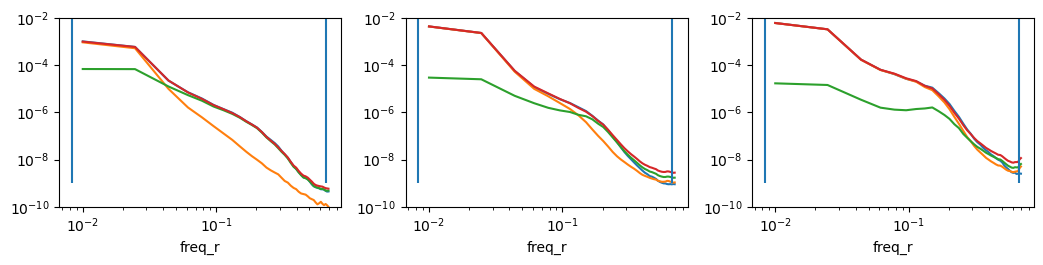

In [12]:
ds = eval_datasets['sst_ssh']

plt.figure(figsize=(14,2.75))

for i, k in enumerate(bins.keys()): 

    samps = bins[k]
    psd_ssh_raw = isotropic_spectra(ds.sel(sample=samps).ssh)
    psd_bm = isotropic_spectra(ds.sel(sample=samps).bm_truth)
    psd_ubm = isotropic_spectra(ds.sel(sample=samps).ubm_truth)

    plt.subplot(1,4,i+1)
    psd_ssh_raw.mean('sample').plot()
    psd_bm.mean('sample').plot()
    psd_ubm.mean('sample').plot()
    (psd_bm.mean('sample') + psd_ubm.mean('sample')).plot()
    
    plt.vlines([1/120, 1/1.5], 1e-9, 1e-2)

    plt.ylim([1e-10, 1e-2])
    plt.xscale('log')
    plt.yscale('log')

plt.tight_layout()
plt.show()

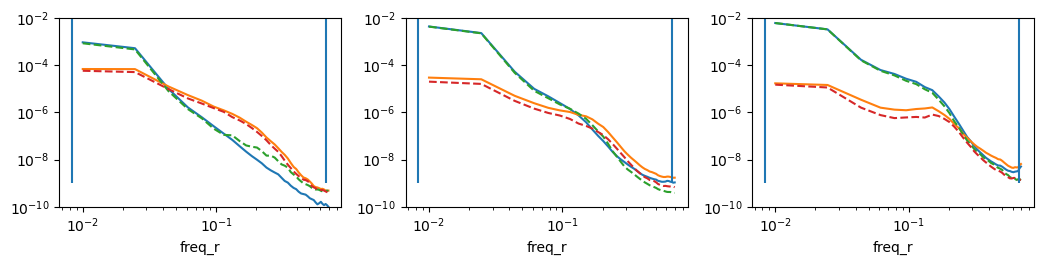

In [13]:
ds = eval_datasets['sst_ssh']

plt.figure(figsize=(14,2.75))

for i, k in enumerate(bins.keys()): 

    samps = bins[k]
    #psd_ssh_raw = isotropic_spectra(ds.sel(sample=samps).ssh)
    psd_bm = isotropic_spectra(ds.sel(sample=samps).bm_truth)
    psd_ubm = isotropic_spectra(ds.sel(sample=samps).ubm_truth)

    psd_bm_pred = isotropic_spectra(ds.sel(sample=samps).bm_pred_mean)
    psd_ubm_pred = isotropic_spectra(ds.sel(sample=samps).ubm_pred_mean)

    plt.subplot(1,4,i+1)
    
    psd_bm.mean('sample').plot()
    psd_ubm.mean('sample').plot()

    psd_bm_pred.mean('sample').plot(linestyle='dashed')
    psd_ubm_pred.mean('sample').plot(linestyle='dashed')
    
    
    plt.vlines([1/120, 1/1.5], 1e-9, 1e-2)

    plt.ylim([1e-10, 1e-2])
    plt.xscale('log')
    plt.yscale('log')

plt.tight_layout()
plt.show()

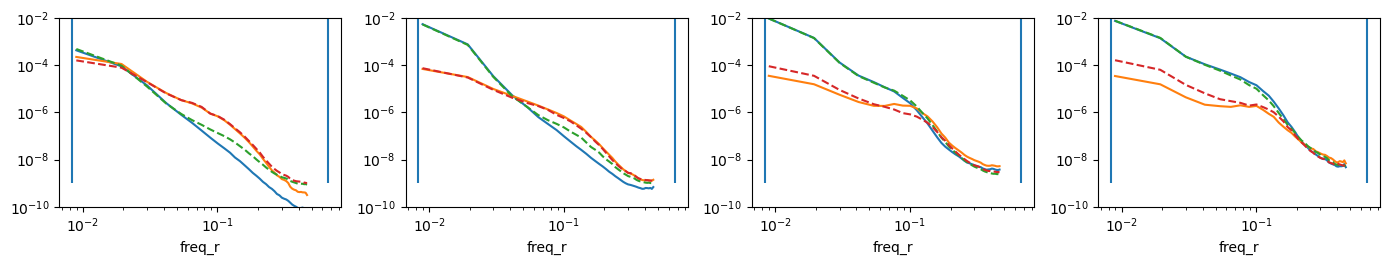

In [58]:
ds = eval_datasets['sst_ssh']

plt.figure(figsize=(14,2.75))

for i, k in enumerate(bins.keys()): 

    samps = bins[k]
    #psd_ssh_raw = isotropic_spectra(ds.sel(sample=samps).ssh)
    psd_bm = isotropic_spectra(ds.sel(sample=samps).bm_truth)
    psd_ubm = isotropic_spectra(ds.sel(sample=samps).ubm_truth)

    psd_bm_pred = isotropic_spectra(ds.sel(sample=samps).bm_pred_samples)
    psd_ubm_pred = isotropic_spectra(ds.sel(sample=samps).ubm_pred_samples)

    plt.subplot(1,4,i+1)
    
    psd_bm.mean('sample').plot()
    psd_ubm.mean('sample').plot()

    psd_bm_pred.mean(['sample','stochastic_sample']).plot(linestyle='dashed')
    psd_ubm_pred.mean(['sample','stochastic_sample']).plot(linestyle='dashed')
    
    
    plt.vlines([1/120, 1/1.5], 1e-9, 1e-2)

    plt.ylim([1e-10, 1e-2])
    plt.xscale('log')
    plt.yscale('log')

plt.tight_layout()
plt.show()

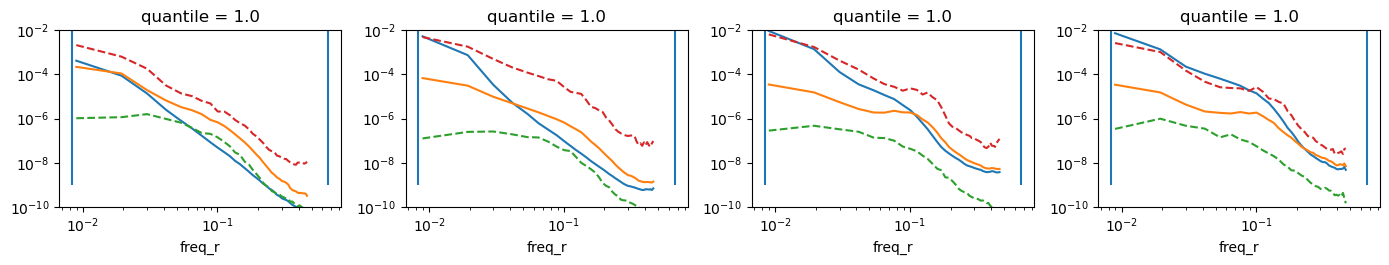

In [59]:
ds = eval_datasets['sst_ssh']

plt.figure(figsize=(14,2.75))

for i, k in enumerate(bins.keys()): 

    samps = bins[k]
    #psd_ssh_raw = isotropic_spectra(ds.sel(sample=samps).ssh)
    psd_bm = isotropic_spectra(ds.sel(sample=samps).bm_truth)
    psd_ubm = isotropic_spectra(ds.sel(sample=samps).ubm_truth)

    psd_bm_pred = isotropic_spectra(ds.sel(sample=samps).bm_pred_samples)
    psd_ubm_pred = isotropic_spectra(ds.sel(sample=samps).ubm_pred_samples)

    plt.subplot(1,4,i+1)
    
    psd_bm.mean('sample').plot()
    psd_ubm.mean('sample').plot()

    psd_ubm_pred.quantile(0, ['sample','stochastic_sample']).plot(linestyle='dashed')
    psd_ubm_pred.quantile(1, ['sample','stochastic_sample']).plot(linestyle='dashed')
    
    
    plt.vlines([1/120, 1/1.5], 1e-9, 1e-2)

    plt.ylim([1e-10, 1e-2])
    plt.xscale('log')
    plt.yscale('log')

plt.tight_layout()
plt.show()

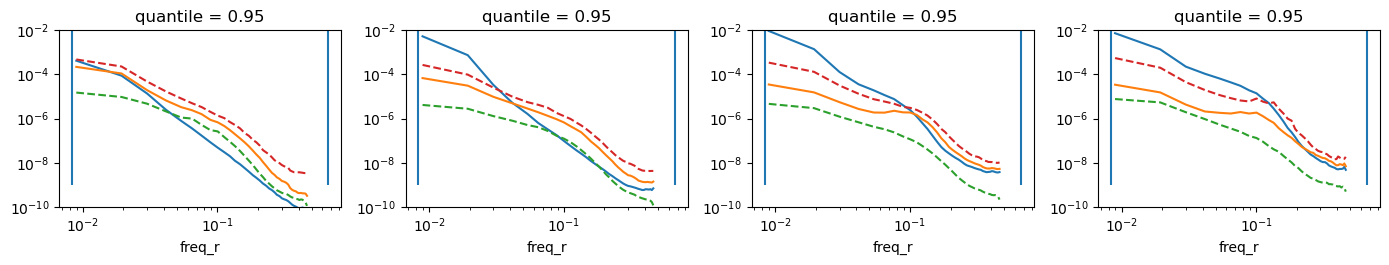

In [60]:
ds = eval_datasets['sst_ssh']

plt.figure(figsize=(14,2.75))

for i, k in enumerate(bins.keys()): 

    samps = bins[k]
    #psd_ssh_raw = isotropic_spectra(ds.sel(sample=samps).ssh)
    psd_bm = isotropic_spectra(ds.sel(sample=samps).bm_truth)
    psd_ubm = isotropic_spectra(ds.sel(sample=samps).ubm_truth)

    psd_bm_pred = isotropic_spectra(ds.sel(sample=samps).bm_pred_samples)
    psd_ubm_pred = isotropic_spectra(ds.sel(sample=samps).ubm_pred_samples)

    plt.subplot(1,4,i+1)
    
    psd_bm.mean('sample').plot()
    psd_ubm.mean('sample').plot()

    psd_ubm_pred.quantile(0.05, ['sample','stochastic_sample']).plot(linestyle='dashed')
    psd_ubm_pred.quantile(.95, ['sample','stochastic_sample']).plot(linestyle='dashed')
    
    
    plt.vlines([1/120, 1/1.5], 1e-9, 1e-2)

    plt.ylim([1e-10, 1e-2])
    plt.xscale('log')
    plt.yscale('log')

plt.tight_layout()
plt.show()

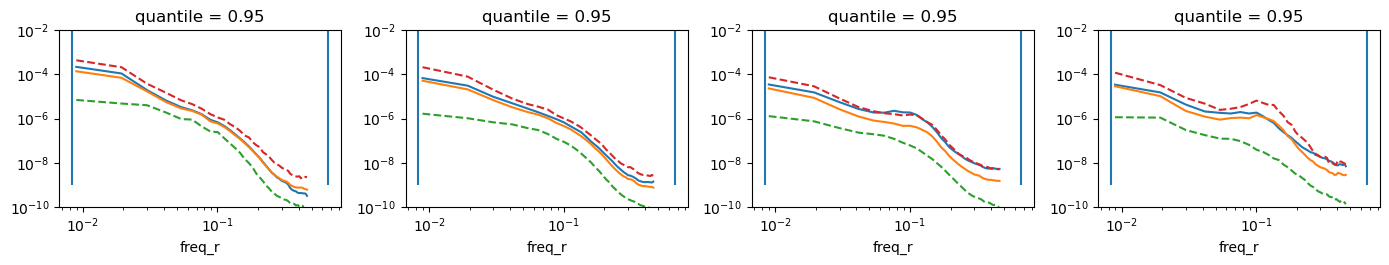

In [63]:
ds = eval_datasets['sst_ssh']

plt.figure(figsize=(14,2.75))

for i, k in enumerate(bins.keys()): 

    samps = bins[k]
    #psd_ssh_raw = isotropic_spectra(ds.sel(sample=samps).ssh)
    psd_bm = isotropic_spectra(ds.sel(sample=samps).bm_truth)
    psd_ubm = isotropic_spectra(ds.sel(sample=samps).ubm_truth)

    psd_bm_pred = isotropic_spectra(ds.sel(sample=samps).bm_pred_mean)
    psd_ubm_pred = isotropic_spectra(ds.sel(sample=samps).ubm_pred_mean)

    plt.subplot(1,4,i+1)
    
    psd_ubm.mean('sample').plot()
    psd_ubm_pred.mean('sample').plot()

    psd_ubm_pred.quantile(0.05, ['sample']).plot(linestyle='dashed')
    psd_ubm_pred.quantile(.95, ['sample']).plot(linestyle='dashed')
    
    
    plt.vlines([1/120, 1/1.5], 1e-9, 1e-2)

    plt.ylim([1e-10, 1e-2])
    plt.xscale('log')
    plt.yscale('log')

plt.tight_layout()
plt.show()

In [14]:
def compute_single_snapshot_calibration(predictions_da, true_values_da, snapshot_idx=0):
    """
    Compute calibration statistics for a single SSH snapshot.
    
    Parameters:
    -----------
    predictions_da : xarray.DataArray
        Predictions with dimensions (sample, i, j, stochastic_sample)
    true_values_da : xarray.DataArray  
        True values with dimensions (sample, i, j)
    snapshot_idx : int
        Which snapshot to analyze (index in the 'sample' dimension)
        
    Returns:
    --------
    calibration_results : dict
        Contains coverage statistics and quantile information
    """
    
    # Select single snapshot
    single_pred = predictions_da.isel(sample=snapshot_idx)  # Shape: (i=80, j=80, stochastic_sample=500)
    single_true = true_values_da.isel(sample=snapshot_idx)  # Shape: (i=80, j=80)
    
    print(f"Working with snapshot {snapshot_idx}")
    print(f"Prediction shape: {single_pred.shape}")
    print(f"True value shape: {single_true.shape}")
    
    # Define quantile levels for different confidence intervals
    confidence_levels = [0.5, 0.8, 0.9, 0.95, 1.0]
    quantile_pairs = {
        0.5: [0.25, 0.75],    # 50% CI: 25th to 75th percentile
        0.8: [0.1, 0.9],      # 80% CI: 10th to 90th percentile  
        0.9: [0.05, 0.95],    # 90% CI: 5th to 95th percentile
        0.95: [0.025, 0.975],  # 95% CI: 2.5th to 97.5th percentile
        1.0: [0.0, 1.0]
    }
    
    # Compute quantiles across stochastic samples for each spatial location
    quantiles_da = single_pred.quantile(
        q=[0.0, 0.025, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.975, 1.0], 
        dim='stochastic_sample'
    )
    
    print(f"Quantiles shape: {quantiles_da.shape}")  # Should be (quantile=9, i=80, j=80)
    
    # Calculate coverage for each confidence level
    coverage_results = {}
    
    for conf_level, (lower_q, upper_q) in quantile_pairs.items():
        # Get lower and upper bounds for this confidence level
        lower_bound = quantiles_da.sel(quantile=lower_q)
        upper_bound = quantiles_da.sel(quantile=upper_q)
        
        # Check which pixels have true value within predicted interval
        within_interval = (single_true >= lower_bound) & (single_true <= upper_bound)
        
        # Calculate coverage (fraction of pixels where truth falls within interval)
        # Handle potential NaN values
        valid_pixels = ~(np.isnan(single_true) | np.isnan(lower_bound) | np.isnan(upper_bound))
        
        if valid_pixels.sum() > 0:
            coverage = within_interval.where(valid_pixels).sum() / valid_pixels.sum()
        else:
            coverage = np.nan
            
        coverage_results[conf_level] = {
            'expected_coverage': conf_level,
            'observed_coverage': float(coverage),
            'n_valid_pixels': int(valid_pixels.sum()),
            'within_interval_map': within_interval.where(valid_pixels)
        }
        
        print(f"{conf_level*100}% CI: Expected {conf_level:.2f}, Observed {coverage:.3f}, "
              f"Valid pixels: {int(valid_pixels.sum())}")
    
    return {
        'coverage_results': coverage_results,
        'quantiles': quantiles_da,
        'true_values': single_true,
        'predictions': single_pred,
        'snapshot_idx': snapshot_idx
    }

In [15]:
temp = compute_single_snapshot_calibration(ds.bm_pred_samples, ds.bm_truth)

Working with snapshot 0
Prediction shape: (100, 80, 80)
True value shape: (80, 80)
Quantiles shape: (11, 80, 80)
50.0% CI: Expected 0.50, Observed 0.562, Valid pixels: 3977
80.0% CI: Expected 0.80, Observed 0.772, Valid pixels: 3977
90.0% CI: Expected 0.90, Observed 0.901, Valid pixels: 3977
95.0% CI: Expected 0.95, Observed 0.960, Valid pixels: 3977
100.0% CI: Expected 1.00, Observed 0.998, Valid pixels: 3977


In [16]:
def compute_pooled_calibration(predictions_da, true_values_da):
    """
    Compute calibration statistics using pixel pooling across all snapshots.
    Treats every pixel from every snapshot as an independent calibration test.
    
    Parameters:
    -----------
    predictions_da : xarray.DataArray
        Predictions with dimensions (sample, i, j, stochastic_sample)
    true_values_da : xarray.DataArray  
        True values with dimensions (sample, i, j)
        
    Returns:
    --------
    calibration_results : dict
        Contains pooled coverage statistics
    """
    
    print(f"Computing pooled calibration across all {predictions_da.sizes['sample']} snapshots")
    print(f"Total pixels to analyze: {predictions_da.sizes['sample'] * predictions_da.sizes['i'] * predictions_da.sizes['j']}")
    
    # Define confidence intervals
    confidence_levels = [0.5, 0.8, 0.9, 0.95, 1.0]
    quantile_pairs = {
        0.5: [0.25, 0.75],
        0.8: [0.1, 0.9], 
        0.9: [0.05, 0.95],
        0.95: [0.025, 0.975],
        1.0 : [0.0, 1.0]
        
    }
    
    # Compute quantiles for all snapshots at once
    print("Computing quantiles across stochastic samples...")
    quantiles_da = predictions_da.quantile(
        q=[0.0,0.025, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.975,1.0],
        dim='stochastic_sample'
    )
    # Shape: (quantile=9, sample=128, i=80, j=80)
    
    print(f"Quantiles shape: {quantiles_da.shape}")
    
    # Calculate coverage by pooling all pixels from all snapshots
    coverage_results = {}
    
    for conf_level, (lower_q, upper_q) in quantile_pairs.items():
        print(f"\nAnalyzing {conf_level*100}% confidence interval...")
        
        # Get bounds for this confidence level (all snapshots, all pixels)
        lower_bound = quantiles_da.sel(quantile=lower_q)  # Shape: (sample=128, i=80, j=80)
        upper_bound = quantiles_da.sel(quantile=upper_q)  # Shape: (sample=128, i=80, j=80)
        
        # Check which pixels have true value within predicted interval
        within_interval = (true_values_da >= lower_bound) & (true_values_da <= upper_bound)
        
        # Identify valid pixels (no NaNs)
        valid_pixels = ~(np.isnan(true_values_da) | np.isnan(lower_bound) | np.isnan(upper_bound))
        
        # Calculate pooled coverage across ALL pixels from ALL snapshots
        if valid_pixels.sum() > 0:
            # This pools across all dimensions: sample, i, j
            total_within = within_interval.where(valid_pixels).sum()
            total_valid = valid_pixels.sum()
            coverage = total_within / total_valid
        else:
            coverage = np.nan
            total_valid = 0
            
        coverage_results[conf_level] = {
            'expected_coverage': conf_level,
            'observed_coverage': float(coverage),
            'n_valid_pixels': int(total_valid),
            'calibration_error': abs(float(coverage) - conf_level)
        }
        
        print(f"  Expected: {conf_level:.3f}, Observed: {coverage:.3f}, "
              f"Error: {abs(float(coverage) - conf_level):.3f}, "
              f"Valid pixels: {int(total_valid):,}")
    
    # Calculate overall calibration error
    errors = [res['calibration_error'] for res in coverage_results.values()]
    mean_calibration_error = np.mean(errors)
    
    print(f"\nOverall mean calibration error: {mean_calibration_error:.4f}")
    
    return {
        'coverage_results': coverage_results,
        'mean_calibration_error': mean_calibration_error,
        'n_snapshots': predictions_da.sizes['sample'],
        'total_pixels_analyzed': sum(res['n_valid_pixels'] for res in coverage_results.values()) // len(coverage_results)
    }


In [17]:
temp = compute_pooled_calibration(ds.ubm_pred_samples, ds.ubm_truth)

Computing pooled calibration across all 3645 snapshots
Total pixels to analyze: 23328000
Computing quantiles across stochastic samples...
Quantiles shape: (11, 3645, 80, 80)

Analyzing 50.0% confidence interval...
  Expected: 0.500, Observed: 0.399, Error: 0.101, Valid pixels: 21,231,623

Analyzing 80.0% confidence interval...
  Expected: 0.800, Observed: 0.631, Error: 0.169, Valid pixels: 21,231,623

Analyzing 90.0% confidence interval...
  Expected: 0.900, Observed: 0.722, Error: 0.178, Valid pixels: 21,231,623

Analyzing 95.0% confidence interval...
  Expected: 0.950, Observed: 0.780, Error: 0.170, Valid pixels: 21,231,623

Analyzing 100.0% confidence interval...
  Expected: 1.000, Observed: 0.866, Error: 0.134, Valid pixels: 21,231,623

Overall mean calibration error: 0.1506


In [18]:
samps = bins['bin_0']
temp = compute_pooled_calibration(ds.ubm_pred_samples.sel(sample=samps), ds.ubm_truth.sel(sample=samps))

Computing pooled calibration across all 524 snapshots
Total pixels to analyze: 3353600
Computing quantiles across stochastic samples...
Quantiles shape: (11, 524, 80, 80)

Analyzing 50.0% confidence interval...
  Expected: 0.500, Observed: 0.282, Error: 0.218, Valid pixels: 3,353,600

Analyzing 80.0% confidence interval...
  Expected: 0.800, Observed: 0.497, Error: 0.303, Valid pixels: 3,353,600

Analyzing 90.0% confidence interval...
  Expected: 0.900, Observed: 0.598, Error: 0.302, Valid pixels: 3,353,600

Analyzing 95.0% confidence interval...
  Expected: 0.950, Observed: 0.668, Error: 0.282, Valid pixels: 3,353,600

Analyzing 100.0% confidence interval...
  Expected: 1.000, Observed: 0.783, Error: 0.217, Valid pixels: 3,353,600

Overall mean calibration error: 0.2646


In [19]:
samps = bins['bin_1']
temp = compute_pooled_calibration(ds.ubm_pred_samples.sel(sample=samps), ds.ubm_truth.sel(sample=samps))

Computing pooled calibration across all 2196 snapshots
Total pixels to analyze: 14054400
Computing quantiles across stochastic samples...
Quantiles shape: (11, 2196, 80, 80)

Analyzing 50.0% confidence interval...
  Expected: 0.500, Observed: 0.373, Error: 0.127, Valid pixels: 14,054,400

Analyzing 80.0% confidence interval...
  Expected: 0.800, Observed: 0.610, Error: 0.190, Valid pixels: 14,054,400

Analyzing 90.0% confidence interval...
  Expected: 0.900, Observed: 0.707, Error: 0.193, Valid pixels: 14,054,400

Analyzing 95.0% confidence interval...
  Expected: 0.950, Observed: 0.768, Error: 0.182, Valid pixels: 14,054,400

Analyzing 100.0% confidence interval...
  Expected: 1.000, Observed: 0.860, Error: 0.140, Valid pixels: 14,054,400

Overall mean calibration error: 0.1664


In [20]:
samps = bins['bin_2']
temp = compute_pooled_calibration(ds.ubm_pred_samples.sel(sample=samps), ds.ubm_truth.sel(sample=samps))

Computing pooled calibration across all 134 snapshots
Total pixels to analyze: 857600
Computing quantiles across stochastic samples...
Quantiles shape: (11, 134, 80, 80)

Analyzing 50.0% confidence interval...
  Expected: 0.500, Observed: 0.591, Error: 0.091, Valid pixels: 857,600

Analyzing 80.0% confidence interval...
  Expected: 0.800, Observed: 0.837, Error: 0.037, Valid pixels: 857,600

Analyzing 90.0% confidence interval...
  Expected: 0.900, Observed: 0.901, Error: 0.001, Valid pixels: 857,600

Analyzing 95.0% confidence interval...
  Expected: 0.950, Observed: 0.934, Error: 0.016, Valid pixels: 857,600

Analyzing 100.0% confidence interval...
  Expected: 1.000, Observed: 0.971, Error: 0.029, Valid pixels: 857,600

Overall mean calibration error: 0.0350


In [21]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

def compute_single_snapshot_calibration(predictions_da, true_values_da, snapshot_idx=0):
    """
    Compute calibration statistics for a single SSH snapshot.
    
    Parameters:
    -----------
    predictions_da : xarray.DataArray
        Predictions with dimensions (sample, i, j, stochastic_sample)
    true_values_da : xarray.DataArray  
        True values with dimensions (sample, i, j)
    snapshot_idx : int
        Which snapshot to analyze (index in the 'sample' dimension)
        
    Returns:
    --------
    calibration_results : dict
        Contains coverage statistics and quantile information
    """
    
    # Select single snapshot
    single_pred = predictions_da.isel(sample=snapshot_idx)  # Shape: (i=80, j=80, stochastic_sample=500)
    single_true = true_values_da.isel(sample=snapshot_idx)  # Shape: (i=80, j=80)
    
    print(f"Working with snapshot {snapshot_idx}")
    print(f"Prediction shape: {single_pred.shape}")
    print(f"True value shape: {single_true.shape}")
    
    # Define quantile levels for different confidence intervals
    confidence_levels = [0.5, 0.8, 0.9, 0.95]
    quantile_pairs = {
        0.5: [0.25, 0.75],    # 50% CI: 25th to 75th percentile
        0.8: [0.1, 0.9],      # 80% CI: 10th to 90th percentile  
        0.9: [0.05, 0.95],    # 90% CI: 5th to 95th percentile
        0.95: [0.025, 0.975]  # 95% CI: 2.5th to 97.5th percentile
    }
    
    # Compute quantiles across stochastic samples for each spatial location
    quantiles_da = single_pred.quantile(
        q=[0.025, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.975], 
        dim='stochastic_sample'
    )
    
    # Calculate coverage for each confidence level
    coverage_results = {}
    
    for conf_level, (lower_q, upper_q) in quantile_pairs.items():
        # Get lower and upper bounds for this confidence level
        lower_bound = quantiles_da.sel(quantile=lower_q)
        upper_bound = quantiles_da.sel(quantile=upper_q)
        
        # Check which pixels have true value within predicted interval
        within_interval = (single_true >= lower_bound) & (single_true <= upper_bound)
        
        # Calculate coverage (fraction of pixels where truth falls within interval)
        # Handle potential NaN values
        valid_pixels = ~(np.isnan(single_true) | np.isnan(lower_bound) | np.isnan(upper_bound))
        
        if valid_pixels.sum() > 0:
            coverage = within_interval.where(valid_pixels).sum() / valid_pixels.sum()
        else:
            coverage = np.nan
            
        coverage_results[conf_level] = {
            'expected_coverage': conf_level,
            'observed_coverage': float(coverage),
            'n_valid_pixels': int(valid_pixels.sum()),
            'within_interval_map': within_interval.where(valid_pixels)
        }
        
        print(f"{conf_level*100}% CI: Expected {conf_level:.2f}, Observed {coverage:.3f}, "
              f"Valid pixels: {int(valid_pixels.sum())}")
    
    return {
        'coverage_results': coverage_results,
        'quantiles': quantiles_da,
        'true_values': single_true,
        'predictions': single_pred,
        'snapshot_idx': snapshot_idx
    }

def compute_pooled_calibration(predictions_da, true_values_da):
    """
    Compute calibration statistics using pixel pooling across all snapshots.
    Treats every pixel from every snapshot as an independent calibration test.
    
    Parameters:
    -----------
    predictions_da : xarray.DataArray
        Predictions with dimensions (sample, i, j, stochastic_sample)
    true_values_da : xarray.DataArray  
        True values with dimensions (sample, i, j)
        
    Returns:
    --------
    calibration_results : dict
        Contains pooled coverage statistics
    """
    
    print(f"Computing pooled calibration across all {predictions_da.sizes['sample']} snapshots")
    print(f"Total pixels to analyze: {predictions_da.sizes['sample'] * predictions_da.sizes['i'] * predictions_da.sizes['j']}")
    
    # Define confidence intervals
    confidence_levels = [0.5, 0.8, 0.9, 0.95]
    quantile_pairs = {
        0.5: [0.25, 0.75],
        0.8: [0.1, 0.9], 
        0.9: [0.05, 0.95],
        0.95: [0.025, 0.975]
    }
    
    # Compute quantiles for all snapshots at once
    print("Computing quantiles across stochastic samples...")
    quantiles_da = predictions_da.quantile(
        q=[0.025, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.975],
        dim='stochastic_sample'
    )
    # Shape: (quantile=9, sample=128, i=80, j=80)
    
    print(f"Quantiles shape: {quantiles_da.shape}")
    
    # Calculate coverage by pooling all pixels from all snapshots
    coverage_results = {}
    
    for conf_level, (lower_q, upper_q) in quantile_pairs.items():
        print(f"\nAnalyzing {conf_level*100}% confidence interval...")
        
        # Get bounds for this confidence level (all snapshots, all pixels)
        lower_bound = quantiles_da.sel(quantile=lower_q)  # Shape: (sample=128, i=80, j=80)
        upper_bound = quantiles_da.sel(quantile=upper_q)  # Shape: (sample=128, i=80, j=80)
        
        # Check which pixels have true value within predicted interval
        within_interval = (true_values_da >= lower_bound) & (true_values_da <= upper_bound)
        
        # Identify valid pixels (no NaNs)
        valid_pixels = ~(np.isnan(true_values_da) | np.isnan(lower_bound) | np.isnan(upper_bound))
        
        # Calculate pooled coverage across ALL pixels from ALL snapshots
        if valid_pixels.sum() > 0:
            # This pools across all dimensions: sample, i, j
            total_within = within_interval.where(valid_pixels).sum()
            total_valid = valid_pixels.sum()
            coverage = total_within / total_valid
        else:
            coverage = np.nan
            total_valid = 0
            
        coverage_results[conf_level] = {
            'expected_coverage': conf_level,
            'observed_coverage': float(coverage),
            'n_valid_pixels': int(total_valid),
            'calibration_error': abs(float(coverage) - conf_level)
        }
        
        print(f"  Expected: {conf_level:.3f}, Observed: {coverage:.3f}, "
              f"Error: {abs(float(coverage) - conf_level):.3f}, "
              f"Valid pixels: {int(total_valid):,}")
    
    # Calculate overall calibration metrics
    errors = [res['calibration_error'] for res in coverage_results.values()]
    signed_errors = [res['observed_coverage'] - res['expected_coverage'] for res in coverage_results.values()]
    
    mean_calibration_error = np.mean(errors)  # Magnitude only
    signed_calibration_error = np.mean(signed_errors)  # Direction + magnitude
    
    # Determine confidence bias
    if signed_calibration_error > 0.05:
        confidence_bias = "underconfident"
        bias_strength = "strongly" if abs(signed_calibration_error) > 0.15 else "moderately"
    elif signed_calibration_error < -0.05:
        confidence_bias = "overconfident" 
        bias_strength = "strongly" if abs(signed_calibration_error) > 0.15 else "moderately"
    else:
        confidence_bias = "well-calibrated"
        bias_strength = ""
    
    print(f"\nCalibration Summary:")
    print(f"  Mean calibration error (magnitude): {mean_calibration_error:.4f}")
    print(f"  Signed calibration error: {signed_calibration_error:+.4f}")
    print(f"  Overall assessment: {bias_strength} {confidence_bias}".strip())
    
    if confidence_bias == "overconfident":
        print(f"  → Model claims higher confidence than justified")
        print(f"  → Prediction intervals are too narrow")
    elif confidence_bias == "underconfident":
        print(f"  → Model is too conservative")  
        print(f"  → Prediction intervals are too wide")
    
    return {
        'coverage_results': coverage_results,
        'mean_calibration_error': mean_calibration_error,
        'signed_calibration_error': signed_calibration_error,
        'confidence_bias': confidence_bias,
        'bias_strength': bias_strength,
        'n_snapshots': predictions_da.sizes['sample'],
        'total_pixels_analyzed': sum(res['n_valid_pixels'] for res in coverage_results.values()) // len(coverage_results)
    }

def plot_pooled_calibration(calibration_results, title="Pooled SSH Calibration"):
    """
    Plot calibration curve for pooled results.
    """
    coverage_res = calibration_results['coverage_results']
    
    # Extract expected vs observed coverage
    expected = [res['expected_coverage'] for res in coverage_res.values()]
    observed = [res['observed_coverage'] for res in coverage_res.values()]
    errors = [res['calibration_error'] for res in coverage_res.values()]
    
    plt.figure(figsize=(10, 8))
    
    # Main calibration plot
    plt.plot([0, 1], [0, 1], 'k--', alpha=0.7, linewidth=2, label='Perfect calibration')
    plt.plot(expected, observed, 'ro-', linewidth=3, markersize=10, label='Observed calibration')
    
    # Add error bars (could represent confidence intervals if you computed them)
    plt.errorbar(expected, observed, yerr=errors, capsize=5, capthick=2, alpha=0.7)
    
    plt.xlabel('Expected Coverage', fontsize=14)
    plt.ylabel('Observed Coverage', fontsize=14) 
    plt.title(title, fontsize=16)
    plt.legend(fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    
    # Add statistics text box with directional information
    mean_error = calibration_results['mean_calibration_error']
    signed_error = calibration_results['signed_calibration_error']
    bias_type = calibration_results['confidence_bias']
    bias_strength = calibration_results['bias_strength']
    n_pixels = calibration_results['total_pixels_analyzed']
    n_snapshots = calibration_results['n_snapshots']
    
    stats_text = f'Mean Cal. Error: {mean_error:.4f}\n'
    stats_text += f'Signed Error: {signed_error:+.4f}\n'
    stats_text += f'Assessment: {bias_strength} {bias_type}'.strip() + '\n'
    stats_text += f'Snapshots: {n_snapshots}\n'
    stats_text += f'Pixels: {n_pixels:,}'
    
    plt.text(0.05, 0.95, stats_text, transform=plt.gca().transAxes, fontsize=11,
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8),
             verticalalignment='top')
    
    # Add point labels
    for exp, obs, err in zip(expected, observed, errors):
        plt.annotate(f'{obs:.3f}', (exp, obs), xytext=(5, 5), 
                    textcoords='offset points', fontsize=10)
    
    plt.tight_layout()
    plt.show()

def compare_snapshot_vs_pooled(predictions_da, true_values_da, snapshot_indices=[0, 10, 20]):
    """
    Compare individual snapshot calibration vs pooled calibration.
    """
    print("="*80)
    print("COMPARISON: Individual Snapshots vs Pooled Calibration")
    print("="*80)
    
    # Compute pooled calibration
    print("\n--- POOLED CALIBRATION (ALL SNAPSHOTS) ---")
    pooled_results = compute_pooled_calibration(predictions_da, true_values_da)
    
    # Compute individual snapshots
    snapshot_results = {}
    print(f"\n--- INDIVIDUAL SNAPSHOT CALIBRATION ---")
    for idx in snapshot_indices:
        print(f"\nSnapshot {idx}:")
        results = compute_single_snapshot_calibration(predictions_da, true_values_da, idx)
        snapshot_results[idx] = results
    
    # Plot comparison
    fig, axes = plt.subplots(1, len(snapshot_indices) + 1, figsize=(20, 5))
    
    # Plot individual snapshots
    for i, idx in enumerate(snapshot_indices):
        ax = axes[i]
        coverage_res = snapshot_results[idx]['coverage_results']
        expected = [res['expected_coverage'] for res in coverage_res.values()]
        observed = [res['observed_coverage'] for res in coverage_res.values()]
        
        ax.plot([0, 1], [0, 1], 'k--', alpha=0.7)
        ax.plot(expected, observed, 'bo-', linewidth=2, markersize=6)
        ax.set_title(f'Snapshot {idx}')
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
        ax.grid(True, alpha=0.3)
        if i == 0:
            ax.set_ylabel('Observed Coverage')
        ax.set_xlabel('Expected Coverage')
    
    # Plot pooled results
    ax = axes[-1]
    coverage_res = pooled_results['coverage_results']
    expected = [res['expected_coverage'] for res in coverage_res.values()]
    observed = [res['observed_coverage'] for res in coverage_res.values()]
    
    ax.plot([0, 1], [0, 1], 'k--', alpha=0.7)
    ax.plot(expected, observed, 'ro-', linewidth=3, markersize=8)
    ax.set_title('Pooled (All Snapshots)')
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.grid(True, alpha=0.3)
    ax.set_xlabel('Expected Coverage')
    
    plt.tight_layout()
    plt.show()
    
    return pooled_results, snapshot_results

def analyze_confidence_bias_details(calibration_results):
    """
    Detailed breakdown of over/under-confidence by confidence level.
    """
    print("\n" + "="*60)
    print("DETAILED CONFIDENCE BIAS ANALYSIS")
    print("="*60)
    
    coverage_res = calibration_results['coverage_results']
    
    print(f"{'Confidence Level':<15} {'Expected':<10} {'Observed':<10} {'Error':<10} {'Bias Type':<15}")
    print("-" * 70)
    
    for conf_level in sorted(coverage_res.keys()):
        expected = coverage_res[conf_level]['expected_coverage']
        observed = coverage_res[conf_level]['observed_coverage']
        signed_error = observed - expected
        
        if signed_error > 0.02:
            bias = "underconfident"
        elif signed_error < -0.02:
            bias = "overconfident"
        else:
            bias = "well-calibrated"
            
        print(f"{conf_level*100:>4.0f}% CI{'':<8} {expected:<10.3f} {observed:<10.3f} "
              f"{signed_error:+.3f}{'':<5} {bias:<15}")
    
    # Pattern analysis
    signed_errors = [coverage_res[cl]['observed_coverage'] - coverage_res[cl]['expected_coverage'] 
                     for cl in sorted(coverage_res.keys())]
    
    print(f"\nPattern Analysis:")
    print(f"  All confidence levels show same bias: {'Yes' if all(e > 0 for e in signed_errors) or all(e < 0 for e in signed_errors) else 'No'}")
    print(f"  Bias magnitude increases with confidence level: {'Yes' if all(signed_errors[i] <= signed_errors[i+1] for i in range(len(signed_errors)-1)) or all(signed_errors[i] >= signed_errors[i+1] for i in range(len(signed_errors)-1)) else 'No'}")
    
    return signed_errors

# Main usage function
def run_pooled_calibration_analysis(predictions_da, true_values_da):
    """
    Complete pooled calibration analysis with confidence bias detection.
    """
    print("="*80)
    print("POOLED CALIBRATION ANALYSIS")  
    print("="*80)
    
    # Compute pooled calibration
    results = compute_pooled_calibration(predictions_da, true_values_da)
    
    # Detailed bias analysis
    analyze_confidence_bias_details(results)
    
    # Plot results
    plot_pooled_calibration(results)
    
    return results

In [22]:
ds

<xarray.Dataset> Size: 19GB
Dimensions:            (sample: 3645, i: 80, j: 80, stochastic_sample: 100)
Coordinates:
  * sample             (sample) int64 29kB 0 1 2 3 4 ... 3641 3642 3643 3644
  * i                  (i) int64 640B 0 1 2 3 4 5 6 7 ... 73 74 75 76 77 78 79
  * j                  (j) int64 640B 0 1 2 3 4 5 6 7 ... 73 74 75 76 77 78 79
  * stochastic_sample  (stochastic_sample) int64 800B 0 1 2 3 4 ... 96 97 98 99
Data variables:
    ssh                (sample, i, j) float32 93MB 0.0 0.0 0.0 ... 0.0 0.0 0.0
    ubm_truth          (sample, i, j) float32 93MB nan nan nan ... nan nan nan
    bm_truth           (sample, i, j) float32 93MB nan nan nan ... nan nan nan
    ubm_pred_mean      (sample, i, j) float32 93MB 0.004772 ... -0.002294
    bm_pred_mean       (sample, i, j) float32 93MB -0.004772 ... 0.002294
    sst                (sample, i, j) float32 93MB 0.06335 0.05314 ... 0.0 0.0
    ubm_pred_samples   (sample, stochastic_sample, i, j) float32 9GB 0.000528...
    bm_pred_samples    (sample, stochastic_sample, i, j) float32 9GB -0.00052...

POOLED CALIBRATION ANALYSIS
Computing pooled calibration across all 524 snapshots
Total pixels to analyze: 3353600
Computing quantiles across stochastic samples...
Quantiles shape: (9, 524, 80, 80)

Analyzing 50.0% confidence interval...
  Expected: 0.500, Observed: 0.282, Error: 0.218, Valid pixels: 3,353,600

Analyzing 80.0% confidence interval...
  Expected: 0.800, Observed: 0.497, Error: 0.303, Valid pixels: 3,353,600

Analyzing 90.0% confidence interval...
  Expected: 0.900, Observed: 0.598, Error: 0.302, Valid pixels: 3,353,600

Analyzing 95.0% confidence interval...
  Expected: 0.950, Observed: 0.668, Error: 0.282, Valid pixels: 3,353,600

Calibration Summary:
  Mean calibration error (magnitude): 0.2764
  Signed calibration error: -0.2764
Overall assessment: strongly overconfident
  → Model claims higher confidence than justified
  → Prediction intervals are too narrow

DETAILED CONFIDENCE BIAS ANALYSIS
Confidence Level Expected   Observed   Error      Bias Type      
---------

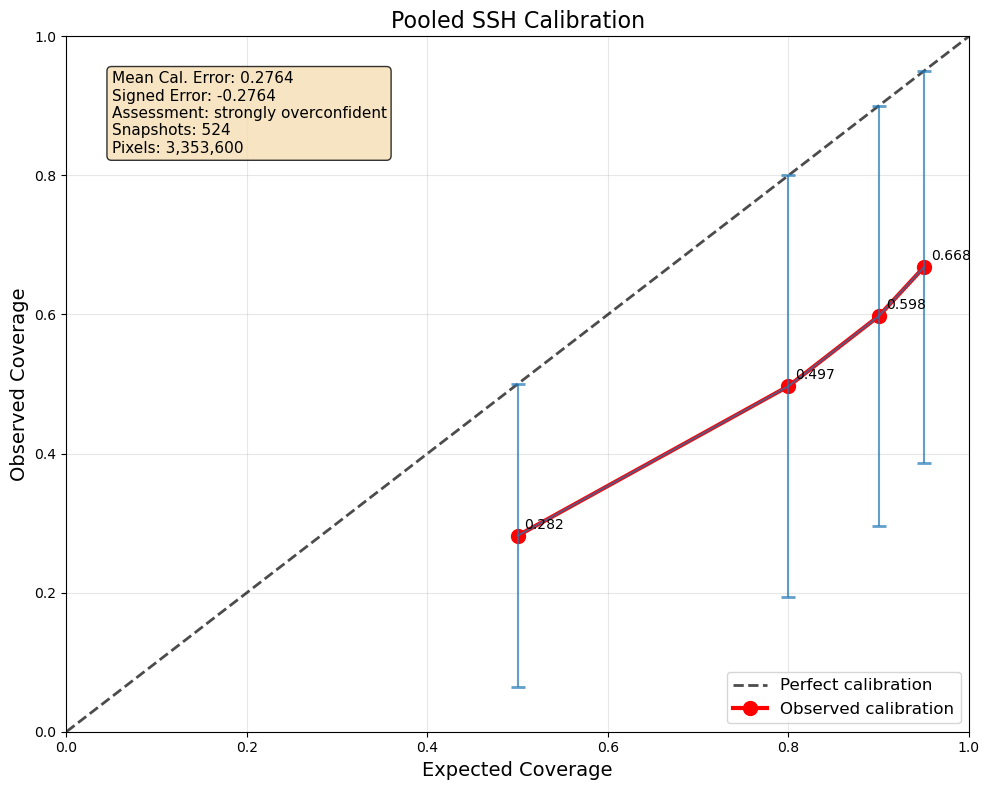

{'coverage_results': {0.5: {'expected_coverage': 0.5,
   'observed_coverage': 0.2819083969465649,
   'n_valid_pixels': 3353600,
   'calibration_error': 0.2180916030534351},
  0.8: {'expected_coverage': 0.8,
   'observed_coverage': 0.49686307251908396,
   'n_valid_pixels': 3353600,
   'calibration_error': 0.3031369274809161},
  0.9: {'expected_coverage': 0.9,
   'observed_coverage': 0.5975793177480916,
   'n_valid_pixels': 3353600,
   'calibration_error': 0.30242068225190843},
  0.95: {'expected_coverage': 0.95,
   'observed_coverage': 0.6678950978053435,
   'n_valid_pixels': 3353600,
   'calibration_error': 0.28210490219465645}},
 'mean_calibration_error': np.float64(0.276438528745229),
 'signed_calibration_error': np.float64(-0.276438528745229),
 'confidence_bias': 'overconfident',
 'bias_strength': 'strongly',
 'n_snapshots': 524,
 'total_pixels_analyzed': 3353600}

In [24]:
#for i, k in enumerate(bins.keys()): 

samps = bins['bin_0']
    #psd_ssh_raw = isotropic_spectra(ds.sel(sample=samps).ssh)
    # psd_bm = isotropic_spectra(ds.sel(sample=samps).bm_truth)
    # psd_ubm = isotropic_spectra(ds.sel(sample=samps).ubm_truth)

    # psd_bm_pred = isotropic_spectra(ds.sel(sample=samps).bm_pred_mean)
    # psd_ubm_pred = isotropic_spectra(ds.sel(sample=samps).ubm_pred_mean)

run_pooled_calibration_analysis(ds.sel(sample=samps).ubm_pred_samples, 
                                ds.sel(sample=samps).ubm_truth)

POOLED CALIBRATION ANALYSIS
Computing pooled calibration across all 2196 snapshots
Total pixels to analyze: 14054400
Computing quantiles across stochastic samples...
Quantiles shape: (9, 2196, 80, 80)

Analyzing 50.0% confidence interval...
  Expected: 0.500, Observed: 0.373, Error: 0.127, Valid pixels: 14,054,400

Analyzing 80.0% confidence interval...
  Expected: 0.800, Observed: 0.610, Error: 0.190, Valid pixels: 14,054,400

Analyzing 90.0% confidence interval...
  Expected: 0.900, Observed: 0.707, Error: 0.193, Valid pixels: 14,054,400

Analyzing 95.0% confidence interval...
  Expected: 0.950, Observed: 0.768, Error: 0.182, Valid pixels: 14,054,400

Calibration Summary:
  Mean calibration error (magnitude): 0.1731
  Signed calibration error: -0.1731
Overall assessment: strongly overconfident
  → Model claims higher confidence than justified
  → Prediction intervals are too narrow

DETAILED CONFIDENCE BIAS ANALYSIS
Confidence Level Expected   Observed   Error      Bias Type      
--

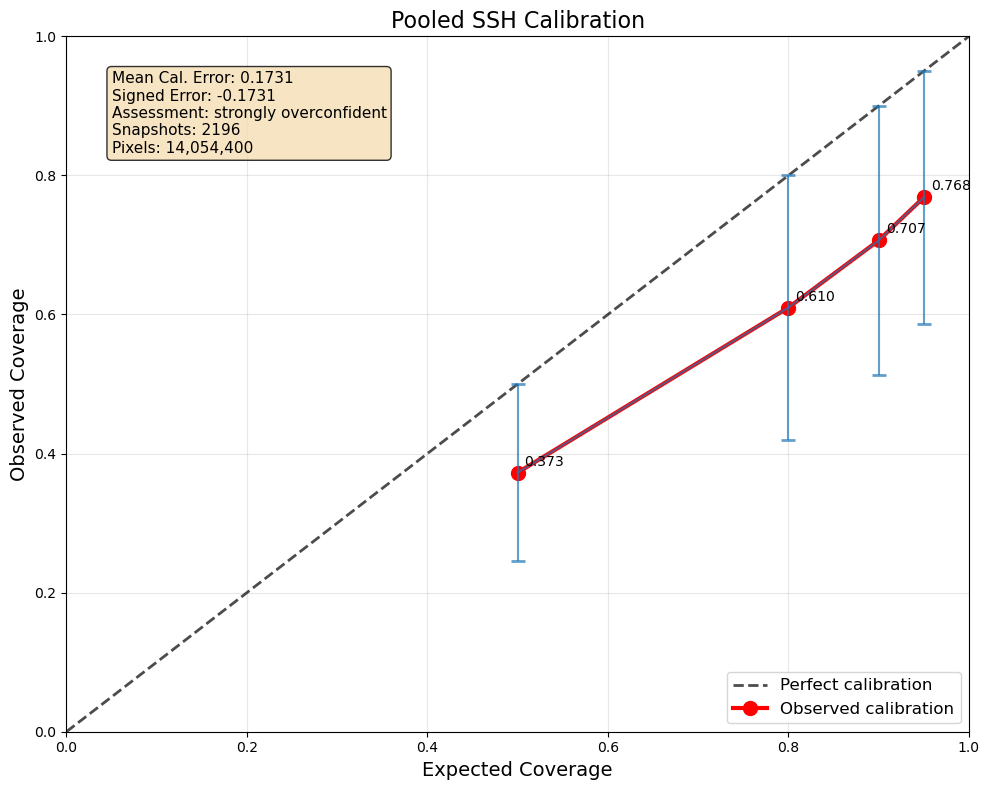

{'coverage_results': {0.5: {'expected_coverage': 0.5,
   'observed_coverage': 0.37268172244990894,
   'n_valid_pixels': 14054400,
   'calibration_error': 0.12731827755009106},
  0.8: {'expected_coverage': 0.8,
   'observed_coverage': 0.6099352515938069,
   'n_valid_pixels': 14054400,
   'calibration_error': 0.19006474840619314},
  0.9: {'expected_coverage': 0.9,
   'observed_coverage': 0.7065218010018215,
   'n_valid_pixels': 14054400,
   'calibration_error': 0.19347819899817853},
  0.95: {'expected_coverage': 0.95,
   'observed_coverage': 0.7684979081284153,
   'n_valid_pixels': 14054400,
   'calibration_error': 0.18150209187158461}},
 'mean_calibration_error': np.float64(0.17309082920651184),
 'signed_calibration_error': np.float64(-0.17309082920651184),
 'confidence_bias': 'overconfident',
 'bias_strength': 'strongly',
 'n_snapshots': 2196,
 'total_pixels_analyzed': 14054400}

In [25]:
#for i, k in enumerate(bins.keys()): 

samps = bins['bin_1']
    #psd_ssh_raw = isotropic_spectra(ds.sel(sample=samps).ssh)
    # psd_bm = isotropic_spectra(ds.sel(sample=samps).bm_truth)
    # psd_ubm = isotropic_spectra(ds.sel(sample=samps).ubm_truth)

    # psd_bm_pred = isotropic_spectra(ds.sel(sample=samps).bm_pred_mean)
    # psd_ubm_pred = isotropic_spectra(ds.sel(sample=samps).ubm_pred_mean)

run_pooled_calibration_analysis(ds.sel(sample=samps).ubm_pred_samples, ds.sel(sample=samps).ubm_truth)

POOLED CALIBRATION ANALYSIS
Computing pooled calibration across all 134 snapshots
Total pixels to analyze: 857600
Computing quantiles across stochastic samples...
Quantiles shape: (9, 134, 80, 80)

Analyzing 50.0% confidence interval...
  Expected: 0.500, Observed: 0.591, Error: 0.091, Valid pixels: 857,600

Analyzing 80.0% confidence interval...
  Expected: 0.800, Observed: 0.837, Error: 0.037, Valid pixels: 857,600

Analyzing 90.0% confidence interval...
  Expected: 0.900, Observed: 0.901, Error: 0.001, Valid pixels: 857,600

Analyzing 95.0% confidence interval...
  Expected: 0.950, Observed: 0.934, Error: 0.016, Valid pixels: 857,600

Calibration Summary:
  Mean calibration error (magnitude): 0.0364
  Signed calibration error: +0.0284
Overall assessment:  well-calibrated

DETAILED CONFIDENCE BIAS ANALYSIS
Confidence Level Expected   Observed   Error      Bias Type      
----------------------------------------------------------------------
  50% CI         0.500      0.591      +0.0

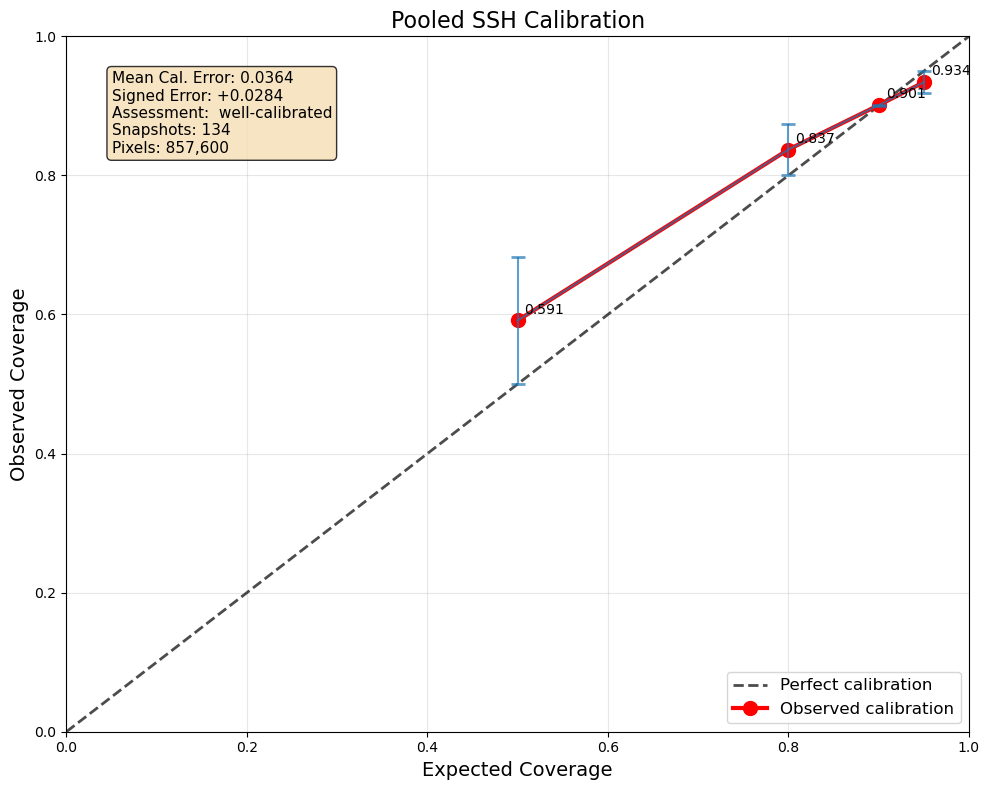

{'coverage_results': {0.5: {'expected_coverage': 0.5,
   'observed_coverage': 0.5914155783582089,
   'n_valid_pixels': 857600,
   'calibration_error': 0.0914155783582089},
  0.8: {'expected_coverage': 0.8,
   'observed_coverage': 0.8372283115671642,
   'n_valid_pixels': 857600,
   'calibration_error': 0.03722831156716411},
  0.9: {'expected_coverage': 0.9,
   'observed_coverage': 0.9009771455223881,
   'n_valid_pixels': 857600,
   'calibration_error': 0.0009771455223880343},
  0.95: {'expected_coverage': 0.95,
   'observed_coverage': 0.9340228544776119,
   'n_valid_pixels': 857600,
   'calibration_error': 0.015977145522388048}},
 'mean_calibration_error': np.float64(0.03639954524253727),
 'signed_calibration_error': np.float64(0.02841097248134325),
 'confidence_bias': 'well-calibrated',
 'bias_strength': '',
 'n_snapshots': 134,
 'total_pixels_analyzed': 857600}

In [26]:
#for i, k in enumerate(bins.keys()): 

samps = bins['bin_2']
    #psd_ssh_raw = isotropic_spectra(ds.sel(sample=samps).ssh)
    # psd_bm = isotropic_spectra(ds.sel(sample=samps).bm_truth)
    # psd_ubm = isotropic_spectra(ds.sel(sample=samps).ubm_truth)

    # psd_bm_pred = isotropic_spectra(ds.sel(sample=samps).bm_pred_mean)
    # psd_ubm_pred = isotropic_spectra(ds.sel(sample=samps).ubm_pred_mean)

run_pooled_calibration_analysis(ds.sel(sample=samps).ubm_pred_samples, ds.sel(sample=samps).ubm_truth)